In [1]:
import transformers
print(transformers.__version__)

import sys, os, json, copy
sys.path.append("..")

from datasets import load_dataset
from transformers import TrainingArguments, DataCollatorWithPadding
from src.EncoderTrainer import EncoderTrainer
from peft import LoraConfig, TaskType
import numpy as np
import torch


5.0.0


## Global Configuration

In [2]:
# ===== paths & constants =====
OUTPUT_FOLDER = "../outputs"
DATA_FOLDER = "../data"

MODEL_NAME = "bert-base-uncased"

TEST_JSON = f"{DATA_FOLDER}/processed/test.json"

MAX_LENGTH = 128
LABELS = ["negative", "neutral", "positive"]
NUM_LABELS = len(LABELS)

LORA_TUNING_DIR = f"{OUTPUT_FOLDER}/lora_tuning/{MODEL_NAME}"
os.makedirs(LORA_TUNING_DIR, exist_ok=True)

## Create Results DataFrame

In [3]:
import pandas as pd

RESULTS_DF = pd.DataFrame(columns=[
    "model",
    "experiment_type",
    "learning_rate",
    "r",
    "lora_alpha",
    "lora_dropout",
    "use_class_weights",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "auc_ovr"
])


In [4]:
trainer = EncoderTrainer(
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    load_in_4bit=False,
)

metrics = trainer.evaluate_classification(
    test_path=TEST_JSON,
    labels=LABELS,
    average="macro",
    verbose=False
)

# ---- store baseline ----
baseline_row = {
    "model": MODEL_NAME,
    "experiment_type": "baseline",   # baseline full fine-tuning
    "learning_rate": None,
    "r": None,
    "lora_alpha": None,
    "lora_dropout": None,
    "use_class_weights": None,
    "accuracy": metrics["accuracy"],
    "precision": metrics["precision"],
    "recall": metrics["recall"],
    "f1": metrics["f1"],
    "auc_ovr": metrics["auc_ovr"],
}

RESULTS_DF = pd.concat(
    [RESULTS_DF, pd.DataFrame([baseline_row])],
    ignore_index=True
)

RESULTS_DF


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.1865205
Max prob: 0.4870863
Row sums (first 5): [1.0000001 1.        0.9999999 1.        1.0000001]
Any NaN in proba: False


/tmp/ipykernel_15385/1526925700.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat(


,model,experiment_type,learning_rate,r,lora_alpha,lora_dropout,use_class_weights,accuracy,precision,recall,f1,auc_ovr
0,bert-base-uncased,baseline,None,None,None,None,None,0.599174,0.202232,0.328798,0.250432,0.494272


In [5]:
from transformers import AutoModelForSequenceClassification

for folder in os.listdir(LORA_TUNING_DIR):
    folder_path = os.path.join(LORA_TUNING_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    config_path = os.path.join(folder_path, "exp_config.json")

    # Skip if no config file
    if not os.path.exists(config_path):
        print(f"Skipping {folder} (no exp_config.json)")
        continue

    print(f"\nEvaluating: {folder}")

    # ----------------------------------
    # Load experiment config (NO parsing)
    # ----------------------------------
    with open(config_path, "r") as f:
        cfg = json.load(f)

    is_lora = cfg.get("use_lora", False)

    # ---- Initialize trainer ----
    trainer = EncoderTrainer(
        model_name=MODEL_NAME,
        num_labels=NUM_LABELS,
        load_in_4bit=False,
    )

    # =====================================================
    # Load model differently depending on method
    # ====================================================
    trainer.load_model(folder_path, use_lora=is_lora)

    # ---- Evaluate ----
    metrics = trainer.evaluate_classification(
        test_path=TEST_JSON,
        labels=LABELS,
        average="macro",
        verbose=True
    )

    row = {
        "model": MODEL_NAME,
        "experiment_type": folder,
        "learning_rate": cfg.get("learning_rate"),
        "r": cfg.get("r"),
        "lora_alpha": cfg.get("lora_alpha"),
        "lora_dropout": cfg.get("lora_dropout"),
        "use_class_weights": cfg.get("use_class_weights"),
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"],
        "auc_ovr": metrics["auc_ovr"],
    }

    print(metrics)

    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)



Evaluating: FFT_LR_0.0002_use_lora_False_learning_rate_0.0002_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Min prob: 0.00046489082
Max prob: 0.99856585
Row sums (first 5): [1.0000001  1.         0.99999994 1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 18   2   3]
 [  8 123  16]
 [  6  15  51]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.56      0.78      0.65        23
     neutral       0.88      0.84      0.86       147
    positive       0.73      0.71      0.72        72

    accuracy                           0.79       242
   macro avg       0.72      0.78      0.74       242
weighted avg       0.80      0.79      0.80       242

{'accuracy': 0.7933884297520661, 'precision': 0.7232142857142857, 'recall': 0.7758922409543528, 'f1': 0.7433327236144137, 'auc_ovr': 0.9165701859478697}

Evaluating: FFT_LR_0.0003_use_lora_False_learning_rate_0.0003_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False


/tmp/ipykernel_15385/2516473360.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Min prob: 0.17362978
Max prob: 0.6405578
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[  0  23   0]
 [  0 147   0]
 [  0  72   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        23
     neutral       0.61      1.00      0.76       147
    positive       0.00      0.00      0.00        72

    accuracy                           0.61       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.37      0.61      0.46       242

{'accuracy': 0.6074380165289256, 'precision': 0.2024793388429752, 'recall': 0.3333333333333333, 'f1': 0.2519280205655527, 'auc_ovr': 0.49801329808539613}

Evaluating: FFT_LR_0.0005_use_lora_False_learning_rate_0.0005_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Min prob: 0.132641
Max prob: 0.6763692
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[  0  23   0]
 [  0 147   0]
 [  0  72   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        23
     neutral       0.61      1.00      0.76       147
    positive       0.00      0.00      0.00        72

    accuracy                           0.61       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.37      0.61      0.46       242

{'accuracy': 0.6074380165289256, 'precision': 0.2024793388429752, 'recall': 0.3333333333333333, 'f1': 0.2519280205655527, 'auc_ovr': 0.4951697642126625}

Evaluating: FFT_LR_0.0006_use_lora_False_learning_rate_0.0006_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Min prob: 0.11411074
Max prob: 0.7155896
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[  0  23   0]
 [  0 147   0]
 [  0  72   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        23
     neutral       0.61      1.00      0.76       147
    positive       0.00      0.00      0.00        72

    accuracy                           0.61       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.37      0.61      0.46       242

{'accuracy': 0.6074380165289256, 'precision': 0.2024793388429752, 'recall': 0.3333333333333333, 'f1': 0.2519280205655527, 'auc_ovr': 0.5}

Evaluating: LORA_ALPHA_16_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_16_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.0003004395
Max prob: 0.99911135
Row sums (first 5): [0.99999994 0.99999994 1.         1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 22   0   1]
 [  7 127  13]
 [  4  16  52]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.67      0.96      0.79        23
     neutral       0.89      0.86      0.88       147
    positive       0.79      0.72      0.75        72

    accuracy                           0.83       242
   macro avg       0.78      0.85      0.81       242
weighted avg       0.84      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.7808857808857809, 'recall': 0.8475631798613166, 'f1': 0.8050665143618666, 'auc_ovr': 0.9501515027537334}

Evaluating: LORA_ALPHA_32_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_32_lora_dropout_0.05_use_class_weights_False


/tmp/ipykernel_15385/2516473360.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00056609605
Max prob: 0.99610186
Row sums (first 5): [1.         1.         0.99999994 1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   1   1]
 [  5 131  11]
 [  4  21  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.70      0.91      0.79        23
     neutral       0.86      0.89      0.87       147
    positive       0.80      0.65      0.72        72

    accuracy                           0.82       242
   macro avg       0.78      0.82      0.79       242
weighted avg       0.82      0.82      0.82       242

{'accuracy': 0.8223140495867769, 'precision': 0.7842731066061076, 'recall': 0.8189925728745604, 'f1': 0.7944478051434699, 'auc_ovr': 0.9489731534478031}

Evaluating: LORA_ALPHA_64_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00069069024
Max prob: 0.991755
Row sums (first 5): [1.         0.99999994 1.         1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   1   1]
 [  4 132  11]
 [  4  21  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.72      0.91      0.81        23
     neutral       0.86      0.90      0.88       147
    positive       0.80      0.65      0.72        72

    accuracy                           0.83       242
   macro avg       0.79      0.82      0.80       242
weighted avg       0.83      0.83      0.82       242

{'accuracy': 0.8264462809917356, 'precision': 0.7926303192229551, 'recall': 0.8212601465707056, 'f1': 0.8007753238536125, 'auc_ovr': 0.9463886681944998}

Evaluating: LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00069069024
Max prob: 0.991755
Row sums (first 5): [1.         0.99999994 1.         1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   1   1]
 [  4 132  11]
 [  4  21  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.72      0.91      0.81        23
     neutral       0.86      0.90      0.88       147
    positive       0.80      0.65      0.72        72

    accuracy                           0.83       242
   macro avg       0.79      0.82      0.80       242
weighted avg       0.83      0.83      0.82       242

{'accuracy': 0.8264462809917356, 'precision': 0.7926303192229551, 'recall': 0.8212601465707056, 'f1': 0.8007753238536125, 'auc_ovr': 0.9463886681944998}

Evaluating: LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_True


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 7.2997376e-05
Max prob: 0.99906856
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   1   1]
 [  6 133   8]
 [  2  22  48]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.72      0.91      0.81        23
     neutral       0.85      0.90      0.88       147
    positive       0.84      0.67      0.74        72

    accuracy                           0.83       242
   macro avg       0.81      0.83      0.81       242
weighted avg       0.84      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.8062690989188267, 'recall': 0.8281573498964803, 'f1': 0.8099220476609378, 'auc_ovr': 0.9421749046978157}

Evaluating: LORA_DROPOUT_0.05_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00069069024
Max prob: 0.991755
Row sums (first 5): [1.         0.99999994 1.         1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   1   1]
 [  4 132  11]
 [  4  21  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.72      0.91      0.81        23
     neutral       0.86      0.90      0.88       147
    positive       0.80      0.65      0.72        72

    accuracy                           0.83       242
   macro avg       0.79      0.82      0.80       242
weighted avg       0.83      0.83      0.82       242

{'accuracy': 0.8264462809917356, 'precision': 0.7926303192229551, 'recall': 0.8212601465707056, 'f1': 0.8007753238536125, 'auc_ovr': 0.9463886681944998}

Evaluating: LORA_DROPOUT_0.0_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_64_lora_dropout_0.0_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 9.302058e-05
Max prob: 0.99928135
Row sums (first 5): [1.        0.9999999 1.0000001 1.        1.       ]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   0   2]
 [  7 123  17]
 [  3  16  53]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.68      0.91      0.78        23
     neutral       0.88      0.84      0.86       147
    positive       0.74      0.74      0.74        72

    accuracy                           0.81       242
   macro avg       0.77      0.83      0.79       242
weighted avg       0.82      0.81      0.82       242

{'accuracy': 0.8140495867768595, 'precision': 0.7661408507602521, 'recall': 0.8286297610831772, 'f1': 0.7913429163429164, 'auc_ovr': 0.9485269043791583}

Evaluating: LORA_DROPOUT_0.1_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_64_lora_dropout_0.1_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 8.455427e-05
Max prob: 0.9992268
Row sums (first 5): [1.         0.99999994 1.         1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 22   0   1]
 [  7 129  11]
 [  2  18  52]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.71      0.96      0.81        23
     neutral       0.88      0.88      0.88       147
    positive       0.81      0.72      0.76        72

    accuracy                           0.84       242
   macro avg       0.80      0.85      0.82       242
weighted avg       0.84      0.84      0.84       242

{'accuracy': 0.8388429752066116, 'precision': 0.7999094799210007, 'recall': 0.8520983272536068, 'f1': 0.8190239058586397, 'auc_ovr': 0.9476901852869921}

Evaluating: LORA_LR_0.0002_use_lora_True_learning_rate_0.0002_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.0016165222
Max prob: 0.98107463
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[ 19   1   3]
 [  3 132  12]
 [ 11  31  30]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.58      0.83      0.68        23
     neutral       0.80      0.90      0.85       147
    positive       0.67      0.42      0.51        72

    accuracy                           0.75       242
   macro avg       0.68      0.71      0.68       242
weighted avg       0.74      0.75      0.73       242

{'accuracy': 0.7479338842975206, 'precision': 0.6824340970682434, 'recall': 0.7135709356206251, 'f1': 0.6800888464875602, 'auc_ovr': 0.8877940714753869}

Evaluating: LORA_LR_0.0003_use_lora_True_learning_rate_0.0003_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00036569632
Max prob: 0.9945299
Row sums (first 5): [1.        1.0000001 1.        1.        1.       ]
Any NaN in proba: False

[Confusion Matrix]
[[ 22   0   1]
 [  5 128  14]
 [  6  23  43]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.67      0.96      0.79        23
     neutral       0.85      0.87      0.86       147
    positive       0.74      0.60      0.66        72

    accuracy                           0.80       242
   macro avg       0.75      0.81      0.77       242
weighted avg       0.80      0.80      0.79       242

{'accuracy': 0.7975206611570248, 'precision': 0.7519093654055974, 'recall': 0.808164086890795, 'f1': 0.7687710499791036, 'auc_ovr': 0.9196551491004504}

Evaluating: LORA_LR_0.0005_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00030256325
Max prob: 0.9980921
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   0   2]
 [  6 130  11]
 [  2  19  51]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.72      0.91      0.81        23
     neutral       0.87      0.88      0.88       147
    positive       0.80      0.71      0.75        72

    accuracy                           0.83       242
   macro avg       0.80      0.84      0.81       242
weighted avg       0.84      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.7978320508369977, 'recall': 0.8352435176969338, 'f1': 0.812023562023562, 'auc_ovr': 0.9470776708818033}

Evaluating: LORA_LR_0.0006_use_lora_True_learning_rate_0.0006_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.0002524903
Max prob: 0.9989033
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   0   2]
 [  7 126  14]
 [  2  19  51]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.70      0.91      0.79        23
     neutral       0.87      0.86      0.86       147
    positive       0.76      0.71      0.73        72

    accuracy                           0.82       242
   macro avg       0.78      0.83      0.80       242
weighted avg       0.82      0.82      0.82       242

{'accuracy': 0.8181818181818182, 'precision': 0.7767198490307085, 'recall': 0.8261732229123533, 'f1': 0.7964264928197013, 'auc_ovr': 0.9460168988304879}

Evaluating: LORA_RANK_16_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_32_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00056609605
Max prob: 0.99610186
Row sums (first 5): [1.         1.         0.99999994 1.         1.        ]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   1   1]
 [  5 131  11]
 [  4  21  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.70      0.91      0.79        23
     neutral       0.86      0.89      0.87       147
    positive       0.80      0.65      0.72        72

    accuracy                           0.82       242
   macro avg       0.78      0.82      0.79       242
weighted avg       0.82      0.82      0.82       242

{'accuracy': 0.8223140495867769, 'precision': 0.7842731066061076, 'recall': 0.8189925728745604, 'f1': 0.7944478051434699, 'auc_ovr': 0.9489731534478031}

Evaluating: LORA_RANK_4_use_lora_True_learning_rate_0.0005_r_4_lora_alpha_8_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00075211056
Max prob: 0.99691796
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[ 22   0   1]
 [  5 131  11]
 [  5  22  45]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.69      0.96      0.80        23
     neutral       0.86      0.89      0.87       147
    positive       0.79      0.62      0.70        72

    accuracy                           0.82       242
   macro avg       0.78      0.82      0.79       242
weighted avg       0.82      0.82      0.81       242

{'accuracy': 0.8181818181818182, 'precision': 0.7777276115124412, 'recall': 0.8242260672384897, 'f1': 0.7903359173126615, 'auc_ovr': 0.9382937694023377}

Evaluating: LORA_RANK_8_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Min prob: 0.00030256325
Max prob: 0.9980921
Row sums (first 5): [1. 1. 1. 1. 1.]
Any NaN in proba: False

[Confusion Matrix]
[[ 21   0   2]
 [  6 130  11]
 [  2  19  51]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.72      0.91      0.81        23
     neutral       0.87      0.88      0.88       147
    positive       0.80      0.71      0.75        72

    accuracy                           0.83       242
   macro avg       0.80      0.84      0.81       242
weighted avg       0.84      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.7978320508369977, 'recall': 0.8352435176969338, 'f1': 0.812023562023562, 'auc_ovr': 0.9470776708818033}


In [6]:
RESULTS_DF

,model,experiment_type,learning_rate,r,lora_alpha,lora_dropout,use_class_weights,accuracy,precision,recall,f1,auc_ovr
0,bert-base-uncased,baseline,NaN,None,None,NaN,None,0.599174,0.202232,0.328798,0.250432,0.494272
1,bert-base-uncased,FFT_LR_0.0002_use_lora_False_learning_rate_0.0...,0.0002,None,None,NaN,False,0.793388,0.723214,0.775892,0.743333,0.916570
2,bert-base-uncased,FFT_LR_0.0003_use_lora_False_learning_rate_0.0...,0.0003,None,None,NaN,False,0.607438,0.202479,0.333333,0.251928,0.498013
3,bert-base-uncased,FFT_LR_0.0005_use_lora_False_learning_rate_0.0...,0.0005,None,None,NaN,False,0.607438,0.202479,0.333333,0.251928,0.495170
4,bert-base-uncased,FFT_LR_0.0006_use_lora_False_learning_rate_0.0...,0.0006,None,None,NaN,False,0.607438,0.202479,0.333333,0.251928,0.500000
5,bert-base-uncased,LORA_ALPHA_16_use_lora_True_learning_rate_0.00...,0.0005,16,16,0.05,False,0.830579,0.780886,0.847563,0.805067,0.950152
6,bert-base-uncased,LORA_ALPHA_32_use_lora_True_learning_rate_0.00...,0.0005,16,32,0.05,False,0.822314,0.784273,0.818993,0.794448,0.948973
7,bert-base-uncased,LORA_ALPHA_64_use_lora_True_learning_rate_0.00...,0.0005,16,64,0.05,False,0.826446,0.792630,0.821260,0.800775,0.946389
8,bert-base-uncased,LORA_CLASS_WEIGHT_use_lora_True_learning_rate_...,0.0005,16,64,0.05,False,0.826446,0.792630,0.821260,0.800775,0.946389
9,bert-base-uncased,LORA_CLASS_WEIGHT_use_lora_True_learning_rate_...,0.0005,16,64,0.05,True,0.834711,0.806269,0.828157,0.809922,0.942175


In [7]:
RESULTS_DF.to_csv(f"{OUTPUT_FOLDER}/experiment_results.csv", index=False)

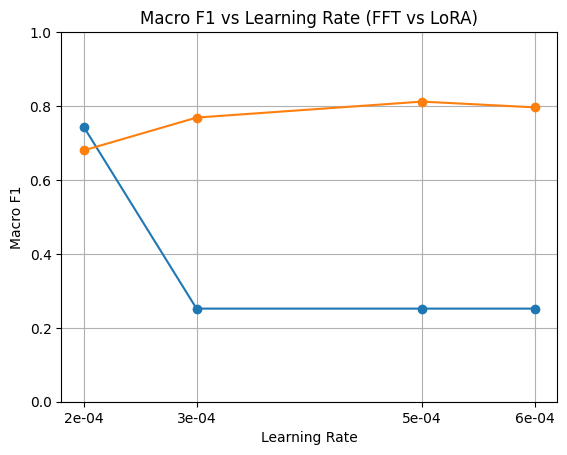

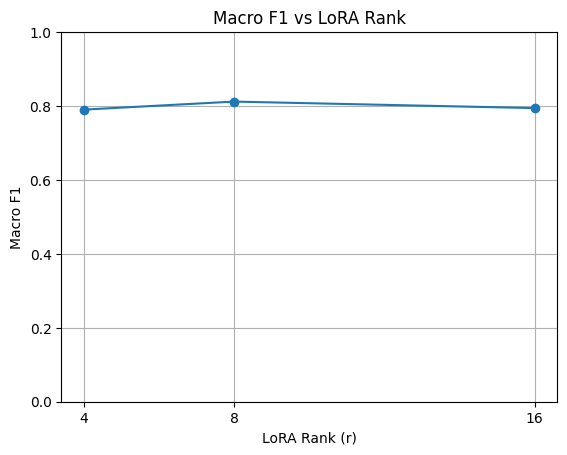

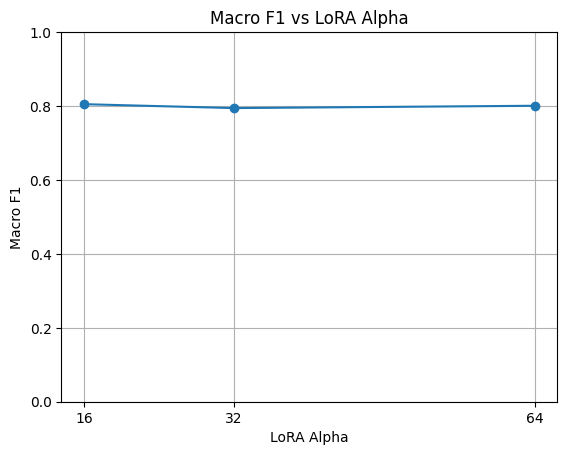

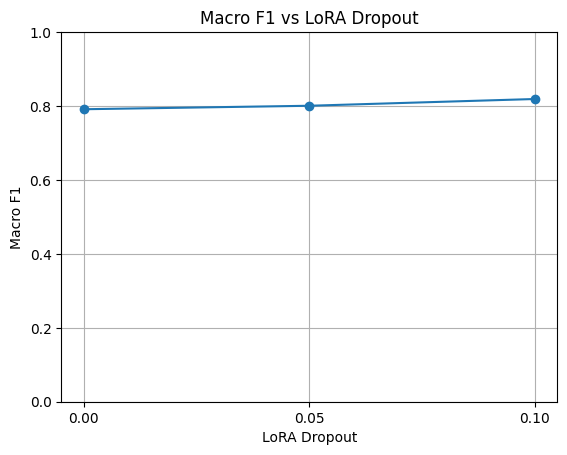

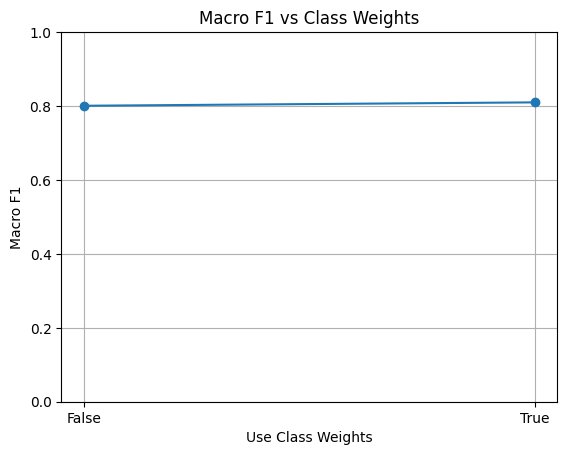

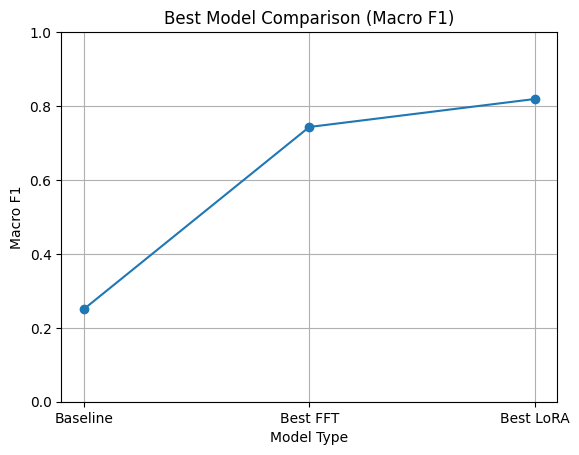

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

df = RESULTS_DF.copy()

# Ensure numeric columns
for col in ["learning_rate", "r", "lora_alpha", "lora_dropout", "f1"]:
    if col in df.columns:
        df[col] = df[col].astype(float)

def finalize_plot(xlabel, title):
    plt.ylim(0, 1)
    plt.xlabel(xlabel)
    plt.ylabel("Macro F1")
    plt.grid(True)
    plt.title(title)
    plt.show()

# ==========================================================
# 1️⃣ Learning Rate (FFT vs LoRA)
# ==========================================================
plt.figure()

fft_df = df[df["experiment_type"].str.startswith("FFT_LR")].sort_values("learning_rate")
lora_lr_df = df[df["experiment_type"].str.startswith("LORA_LR")].sort_values("learning_rate")

plt.plot(fft_df["learning_rate"], fft_df["f1"], marker="o", label="FFT")
plt.plot(lora_lr_df["learning_rate"], lora_lr_df["f1"], marker="o", label="LoRA")

# Highlight best LoRA
best_idx = lora_lr_df["f1"].idxmax()
best_lr = lora_lr_df.loc[best_idx, "learning_rate"]
best_f1 = lora_lr_df.loc[best_idx, "f1"]

plt.scatter(best_lr, best_f1, s=120)
plt.annotate(f"{best_f1:.3f}", (best_lr, best_f1),
             textcoords="offset points", xytext=(0,8), ha='center')

plt.xticks(sorted(lora_lr_df["learning_rate"].unique()))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))

plt.legend()
plt.ylim(0,1)
plt.xlabel("Learning Rate")
plt.ylabel("Macro F1")
plt.title("Macro F1 vs Learning Rate (FFT vs LoRA)")
plt.show()


# ==========================================================
# 2️⃣ LoRA Rank
# ==========================================================
plt.figure()

rank_df = df[df["experiment_type"].str.contains("LORA_RANK", na=False)].sort_values("r")

plt.plot(rank_df["r"], rank_df["f1"], marker="o")
plt.xticks(rank_df["r"])

finalize_plot("LoRA Rank (r)", "Macro F1 vs LoRA Rank")


# ==========================================================
# 3️⃣ LoRA Alpha
# ==========================================================
plt.figure()

alpha_df = df[df["experiment_type"].str.contains("LORA_ALPHA", na=False)].sort_values("lora_alpha")

plt.plot(alpha_df["lora_alpha"], alpha_df["f1"], marker="o")
plt.xticks(alpha_df["lora_alpha"])

finalize_plot("LoRA Alpha", "Macro F1 vs LoRA Alpha")


# ==========================================================
# 4️⃣ LoRA Dropout
# ==========================================================
plt.figure()

dropout_df = df[df["experiment_type"].str.contains("LORA_DROPOUT", na=False)].sort_values("lora_dropout")

plt.plot(dropout_df["lora_dropout"], dropout_df["f1"], marker="o")
plt.xticks(dropout_df["lora_dropout"])

finalize_plot("LoRA Dropout", "Macro F1 vs LoRA Dropout")


# ==========================================================
# 5️⃣ Class Weight
# ==========================================================
plt.figure()

cw_df = df[df["experiment_type"].str.contains("LORA_CLASS_WEIGHT", na=False)]
cw_group = cw_df.groupby("use_class_weights")["f1"].mean().sort_index()

plt.plot(cw_group.index.astype(str), cw_group.values, marker="o")

finalize_plot("Use Class Weights", "Macro F1 vs Class Weights")


# ==========================================================
# 6️⃣ Best LoRA vs FFT vs Baseline
# ==========================================================
plt.figure()

baseline_f1 = df[df["experiment_type"] == "baseline"]["f1"].max()
best_fft_f1 = df[df["experiment_type"].str.contains("FFT", na=False)]["f1"].max()
best_lora_f1 = df[df["experiment_type"].str.contains("LORA", na=False)]["f1"].max()

labels = ["Baseline", "Best FFT", "Best LoRA"]
values = [baseline_f1, best_fft_f1, best_lora_f1]

plt.plot(labels, values, marker="o")

finalize_plot("Model Type", "Best Model Comparison (Macro F1)")


## Load + preprocess test.json

In [ ]:
ds = load_dataset("json", data_files={"test": TEST_JSON})["test"]

tokenizer = trainer.tokenizer
ds = ds.map(lambda ex: format_prompt(ex, tokenizer.eos_token))

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=128,
        padding=False,   # dynamic padding later
    )

tokenized_ds = ds.map(
    tokenize,
    batched=True,
    batch_size=128,
    remove_columns=ds.column_names,
    desc="Tokenizing",
)

## Evaluate with HF Trainer

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,   # causal LM
)

In [ ]:
# ---- 4) Evaluate with HF Trainer ----
eval_args = TrainingArguments(
    output_dir="../outeval_out",
    per_device_eval_batch_size=4,
    dataloader_drop_last=False,
    report_to=[],  # avoid wandb errors
)

In [ ]:
eval_trainer = Trainer(
    model=trainer.model,
    args=eval_args,
    eval_dataset=tokenized_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
metrics = eval_trainer.evaluate()

In [ ]:
metrics
